In [ ]:
import os
import torch
import torchvision
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification import Metrics
from torchcp.utils import fix_randomness
from examples.common.dataset import build_dataset
from torchcp.classification.predictors import ClusterPredictor, ClassWisePredictor, SplitPredictor
from torchcp.regression.predictors import SplitPredictor,CQR
from torchcp.regression.loss import QuantileLoss 
from examples.common.utils import build_regression_model
from torchcp.classification.loss import ConfTr


## Data set and miscellaneous

In [137]:
 transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist = torchvision.datasets.MNIST(root='/shareddata', train=False ,download=True, transform=transform_mnist)
        
mnist_dataloader = torch.utils.data.DataLoader(mnist, shuffle=False, num_workers=2)

In [138]:
mnist_train = torchvision.datasets.MNIST(root='/shareddata', train=True,
                                       download=True, transform=transform_mnist)

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=128,
                                         shuffle=True, num_workers=2)

In [113]:
 transform_svhn = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=224),
    transforms.ToTensor()
])

In [122]:
svhn = torchvision.datasets.SVHN(root='/shareddata', split = 'test',download=True, transform=transform_svhn)
        
svhn_dataloader = torch.utils.data.DataLoader(svhn, shuffle=False, num_workers=2)

svhn_train = torchvision.datasets.SVHN(root='/shareddata', split = 'train',
                                       download=True, transform=transform_mnist)

svhn_train_dataloader = torch.utils.data.DataLoader(svhn_train, batch_size=128,
                                         shuffle=False, num_workers=2)

Using downloaded and verified file: /shareddata\test_32x32.mat
Using downloaded and verified file: /shareddata\train_32x32.mat


In [124]:
print(len(svhn))

26032


In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Classification
---


In [140]:
def train_Classification(model, device,epoch, train_loader,criterion,  optimizer, loss_list):
    
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.detach().cpu().numpy())

In [141]:
model_Res = models.resnet50(pretrained=True)
model_Res.fc = torch.nn.Linear(model_Res.fc.in_features, 10)
model_Res.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

In [131]:
fix_randomness(seed=0)
##################################
# Training a pytorch model
##################################

#train_dataset = build_dataset("mnist")
train_data_loader = svhn_train_dataloader
test_dataset = svhn
cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [13016, 13016])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=100, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)
    
model = model_Res

score_function_list = ['THR','APS']
for score in score_function_list:
    if score == 'THR':
        score_function = THR()
    elif score =='APS':
        score_function = APS()
    model.eval()
    predictor = SplitPredictor(score_function, model)
    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']} with score{score}")

Result--Coverage_rate: 0.968500307314075, Average_size: 9.723647818070068 with scoreTHR
Result--Coverage_rate: 0.9725722188076213, Average_size: 9.752458512599878 with scoreAPS


In [143]:
train_data_loader = mnist_train_dataloader
test_dataset = mnist
cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=100, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)
    
model = model_Res

    
score_function_list = ['THR','APS']
for score in score_function_list:
    if score == 'THR':
        score_function = THR()
    elif score =='APS':
        score_function = APS()
    model.eval()
    predictor = SplitPredictor(score_function, model)
    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']} with score{score}")

Result--Coverage_rate: 0.9892, Average_size: 9.8894 with scoreTHR
Result--Coverage_rate: 0.9922, Average_size: 9.8984 with scoreAPS


## Conformal Training

In [129]:
class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fc1 = nn.Linear(28 * 28, 256)
                self.fc2 = nn.Linear(256, 10)

            def forward(self, x):
                x = x.view(-1, 28 * 28)
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                return x
            

############################## ConfTr #########################
第 1 次训练结束


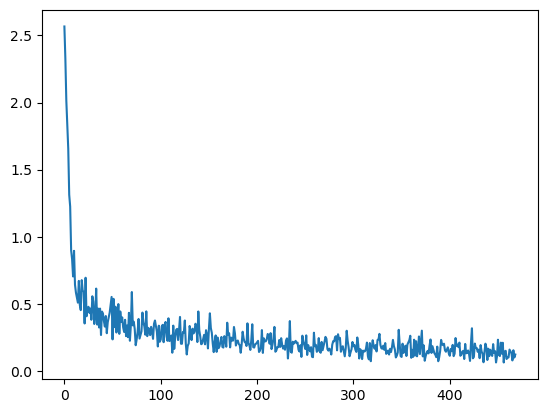

第 2 次训练结束


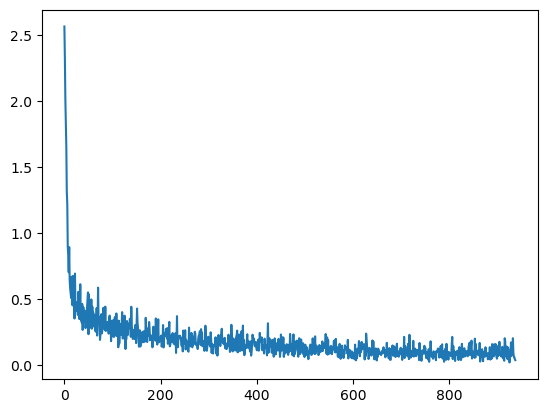

第 3 次训练结束


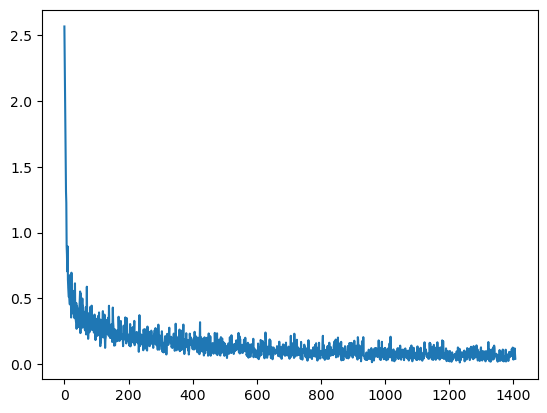

第 4 次训练结束


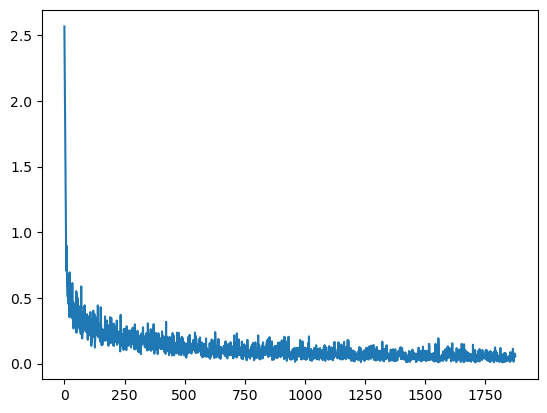

Result--Coverage_rate: 0.9928, Average_size: 1.0534 with scoreTHR
Result--Coverage_rate: 0.9888, Average_size: 1.2192 with scoreAPS


In [49]:
alpha = 0.01
loss = "ConfTr"
result = {}
print(f"############################## {loss} #########################")
    
predictor = SplitPredictor(score_function=THR(score_type="log_softmax"))
criterion = ConfTr(weight=0.01,
                    predictor=predictor,
                    alpha=0.05,
                    fraction=0.5,
                    loss_type="valid",
                    base_loss_fn=nn.CrossEntropyLoss())
        
fix_randomness(seed=0)
##################################
# Training a pytorch model
##################################
#train_dataset = build_dataset("mnist")
train_data_loader = mnist_train_dataloader
test_dataset = mnist
cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=100, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)
    
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
loss_list = []
for epoch in range(1, 5):
    train_Classification(model, device, epoch, train_data_loader, criterion, optimizer,loss_list)
    print(f'第 {epoch} 次' + '训练结束')
    plt.plot(loss_list)
    #if epoch < 3:
        #plt.savefig(f'{epoch}ConfTr')
    plt.show()
    plt.close()
        

score_function_list = ['THR','APS']
for score in score_function_list:
    if score == 'THR':
        score_function = THR()
    elif score =='APS':
        score_function = APS()
            
    model.eval()
    predictor = SplitPredictor(score_function, model)
    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']} with score{score}")

############################## CrossEntropyLoss #########################
第 1 次训练结束


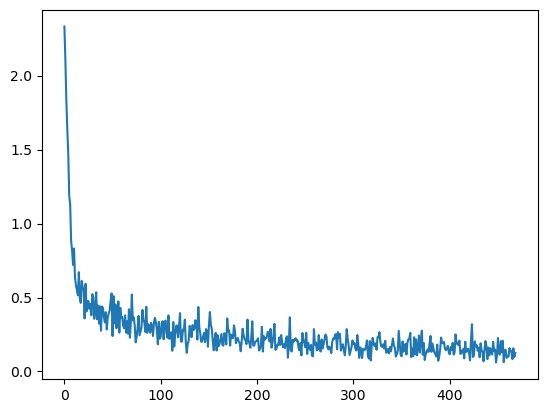

第 2 次训练结束


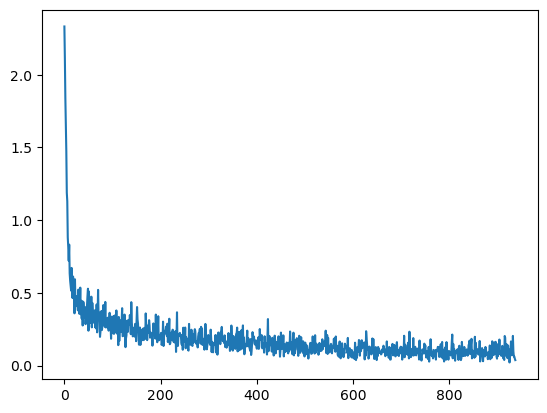

第 3 次训练结束


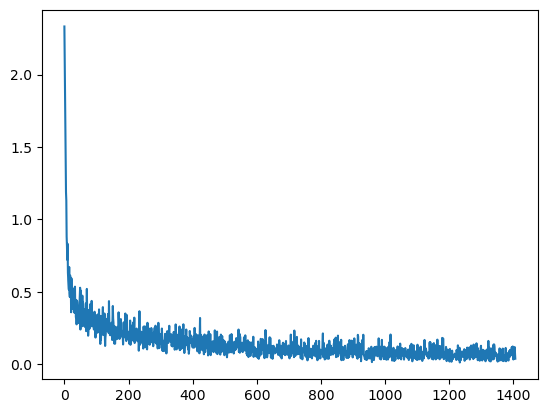

第 4 次训练结束


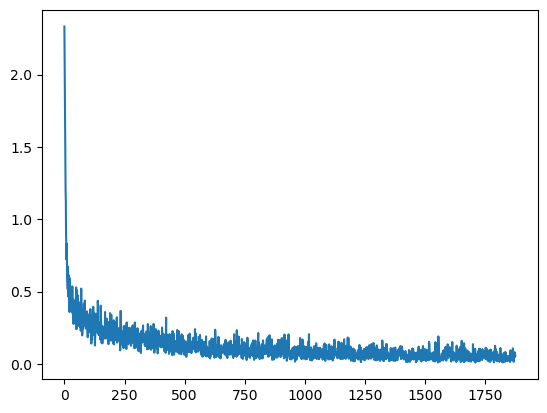

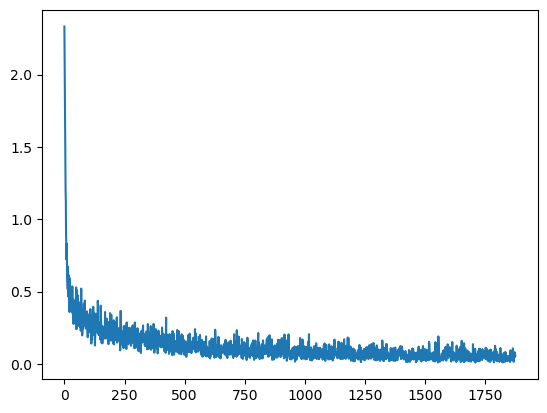

Result--Coverage_rate: 0.9934, Average_size: 1.0548 with scoreTHR
Result--Coverage_rate: 0.9886, Average_size: 1.2156 with scoreAPS


In [50]:
alpha = 0.01
loss = "CrossEntropyLoss"
result = {}
print(f"############################## {loss} #########################")
    
criterion = nn.CrossEntropyLoss()
        
fix_randomness(seed=0)
##################################
# Training a pytorch model
##################################

#train_dataset = build_dataset("mnist")
train_data_loader = mnist_train_dataloader
test_dataset = mnist
cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=100, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)
    
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
Loss_list = []
for epoch in range(1, 5):
    train_Classification(model, device,epoch, train_data_loader, criterion, optimizer, Loss_list)
    print(f'第 {epoch} 次' + '训练结束')
    plt.plot(Loss_list)
    #if epoch < 3:
        #plt.savefig(f'{epoch}CrossEnt')
    plt.show()
    plt.close()


score_function_list = ['THR','APS']
for score in score_function_list:
    if score == 'THR':
        score_function = THR()
    elif score =='APS':
        score_function = APS()
    model.eval()
    predictor = SplitPredictor(score_function, model)
    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']} with score{score}")

## Regression
---

In [145]:
df=pd.read_csv('diamonds.csv')

In [146]:
df.drop('Unnamed: 0',axis='columns',inplace=True)

raw_data = df.copy()

raw_data.drop(raw_data.loc[(raw_data['x']==0)|(raw_data['y']==0)|(raw_data['z']==0)|(raw_data['y']>30)|(raw_data['z']>30)].index,inplace=True)
raw_data.drop(raw_data.loc[raw_data['table']>80].index,inplace=True)
raw_data[raw_data.duplicated()]
raw_data.drop_duplicates(inplace=True)

data_Categorical=raw_data.copy()

In [147]:
#raw_data.drop('color',axis='columns',inplace=True)
#raw_data.drop('clarity',axis='columns',inplace=True)
data_new_ready=pd.get_dummies(raw_data,columns=['cut','color','clarity'],drop_first=True)
#data_new_ready=pd.get_dummies(raw_data,columns=['cut'],drop_first=True)
data_new_ready

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,True,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,False,True,False,...,False,False,False,False,True,False,False,False,False,False
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,True,False,False,...,False,False,False,False,True,False,False,False,False,False
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,False,False,True,...,True,False,False,False,False,True,False,False,False,False


In [148]:
target='price'
X=data_new_ready.drop([target],axis=1)
y=data_new_ready[[target]]

In [149]:
ab,X,_,y = train_test_split(X,y,test_size=0.3,random_state=888)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=5)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size = 0.3, random_state = 5)
#print(y_train.shape)
#print(y_test.shape)
#print(y_cal.shape)

In [150]:
#标准化
SC_X = StandardScaler()
SC_X.fit(X_train)
X_train = SC_X.transform(X_train)
X_test = SC_X.transform(X_test)
X_cal = SC_X.transform(X_cal)

In [151]:
#将dataframe转化为Tensor数据集
train_dataset = TensorDataset(torch.from_numpy(X_train).to(torch.float32), torch.from_numpy(y_train.values).to(torch.float32))
cal_dataset = TensorDataset(torch.from_numpy(X_test).to(torch.float32), torch.from_numpy(y_test.values).to(torch.float32))
test_dataset = TensorDataset(torch.from_numpy(X_cal).to(torch.float32), torch.from_numpy(y_cal.values).to(torch.float32))

#train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train.values))
#cal_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test.values))
#test_dataset = TensorDataset(torch.from_numpy(X_cal), torch.from_numpy(y_cal.values))
                             
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)                            



In [152]:
def train_Reg(model, device, epoch, train_data_loader, criterion, optimizer,loss_list):
    for index, (tmp_x, tmp_y) in enumerate(train_data_loader):
        outputs = model(tmp_x.to(device))
        loss = criterion(outputs, tmp_y.unsqueeze(dim=1).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.detach().cpu().numpy())
        
            

########################## SplitPredictor ###########################


F:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第 1 次训练结束


F:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([96, 1, 1])) that is different to the input size (torch.Size([96, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


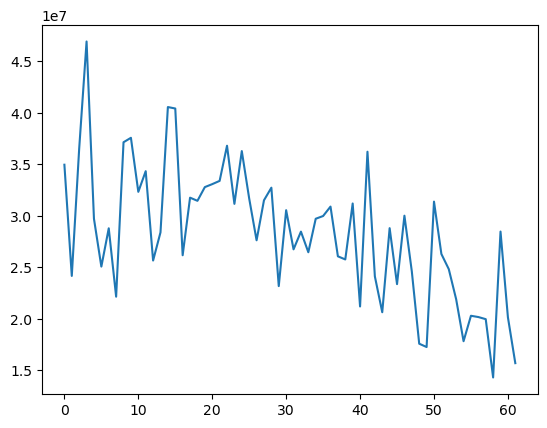

第 2 次训练结束


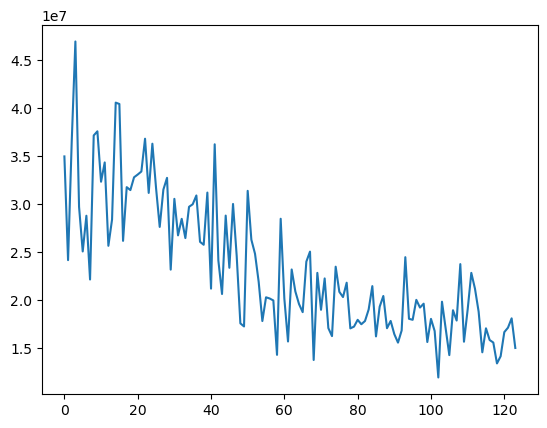

第 3 次训练结束


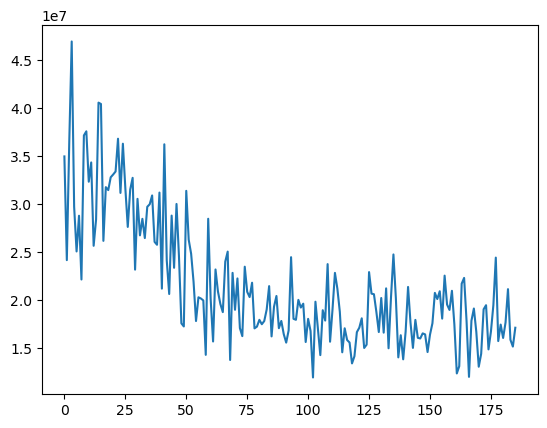

第 4 次训练结束


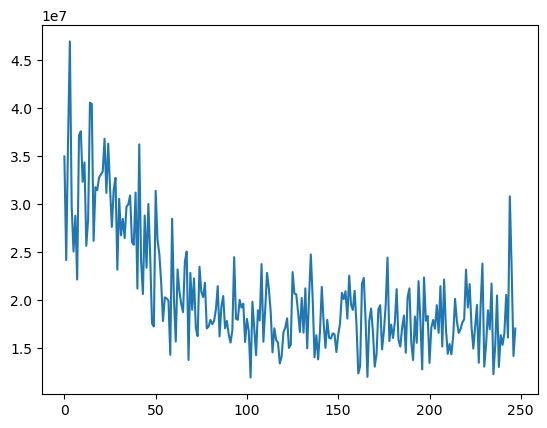

In [153]:
fix_randomness(seed=1)

alpha = 0.01

    ##################################
    # Split Conformal Prediction
    ##################################
print("########################## SplitPredictor ###########################")
model = build_regression_model("NonLinearNet")(X_train.shape[1], 1, 64, 0.5).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_list = []
for epoch in range(1,5):
    train_Reg(model, device,  epoch,train_data_loader, criterion, optimizer,loss_list)
    print(f'第 {epoch} 次' + '训练结束')
    plt.plot(loss_list)
    #plt.savefig(f'{epoch}Split_CP')
    plt.show()
    plt.close()
    


########################## CQR ###########################
第 1 次训练结束


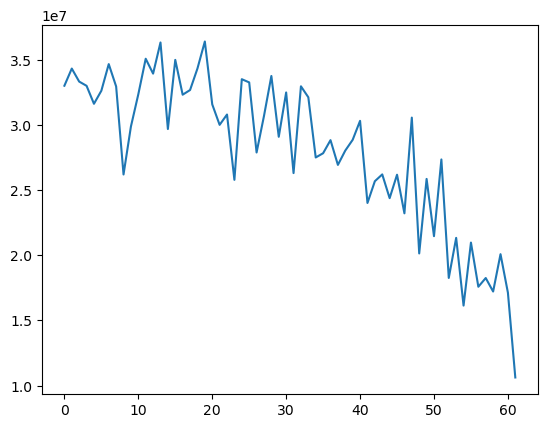

第 2 次训练结束


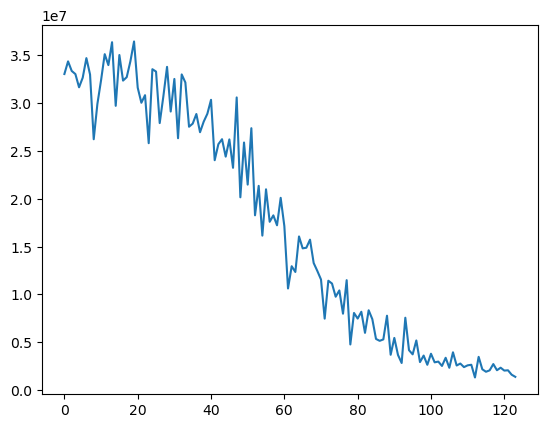

第 3 次训练结束


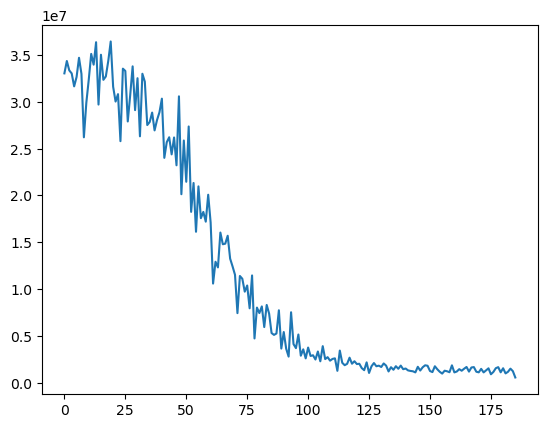

第 4 次训练结束


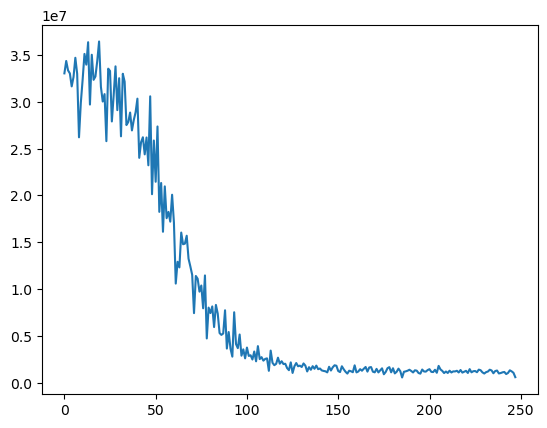

In [154]:
 print("########################## CQR ###########################")

quantiles = [alpha / 2, 1 - alpha / 2]
model = build_regression_model("NonLinearNet")(X_train.shape[1], 2, 64, 0.5).to(device)
criterion = QuantileLoss(quantiles)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_list = []
for epoch in range(1,5):
    train_Reg(model, device,  epoch,train_data_loader, criterion, optimizer,loss_list)
    print(f'第 {epoch} 次' + '训练结束')
    plt.plot(loss_list)
    plt.savefig(f'{epoch}CQR')
    plt.show()
    plt.close()
    
